In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pest/test/beetle/jpg_9.jpg
/kaggle/input/pest/test/beetle/jpg_18.jpg
/kaggle/input/pest/test/beetle/jpg_33.jpg
/kaggle/input/pest/test/beetle/jpg_54.jpg
/kaggle/input/pest/test/beetle/jpg_22.jpg
/kaggle/input/pest/test/beetle/jpg_35.jpg
/kaggle/input/pest/test/beetle/jpg_10.jpg
/kaggle/input/pest/test/beetle/jpg_39.jpg
/kaggle/input/pest/test/beetle/jpg_29.jpg
/kaggle/input/pest/test/beetle/jpg_15.jpg
/kaggle/input/pest/test/beetle/jpg_30.jpg
/kaggle/input/pest/test/beetle/jpg_3.jpg
/kaggle/input/pest/test/beetle/jpg_52.jpg
/kaggle/input/pest/test/beetle/jpg_20.jpg
/kaggle/input/pest/test/beetle/jpg_20 - Copy.jpg
/kaggle/input/pest/test/beetle/jpg_51.jpg
/kaggle/input/pest/test/beetle/jpg_17.jpg
/kaggle/input/pest/test/beetle/jpg_53.jpg
/kaggle/input/pest/test/beetle/jpg_16.jpg
/kaggle/input/pest/test/beetle/jpg_58.jpg
/kaggle/input/pest/test/beetle/jpg_27.jpg
/kaggle/input/pest/test/beetle/jpg_46.jpg
/kaggle/input/pest/test/beetle/jpg_12.jpg
/kaggle/input/pest/test/beetl

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet50
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets for the Pest Dataset
train_dataset = ImageFolder('/kaggle/input/pest/train', transform=transform)
test_dataset = ImageFolder('/kaggle/input/pest/test', transform=transform)

# Create data loaders for the datasets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pretrained ResNet-50 model
resnet = resnet50(pretrained=True)
resnet.eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
# Function to extract features from the dataloader using ResNet-50
def extract_features(loader, model):
    features = []
    labels = []

    with torch.no_grad():
        for images, target in loader:
            features_batch = model(images)
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch)
            labels.append(target)

    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels

# Extract features from the train and test datasets
train_features, train_labels = extract_features(train_loader, resnet)
test_features, test_labels = extract_features(test_loader, resnet)


In [5]:
# Define the logistic regression model for pesticide suggestion
input_size = train_features.shape[1]
output_size = len(train_dataset.classes)  # Update to the number of pest classes
logreg = nn.Linear(input_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(logreg.parameters(), lr=0.001, weight_decay=1)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for features_batch, labels in train_loader:
        optimizer.zero_grad()
        outputs = logreg(train_features)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


Epoch [1/30], Loss: 0.9359919428825378
Epoch [2/30], Loss: 0.6973974108695984
Epoch [3/30], Loss: 0.5929818153381348
Epoch [4/30], Loss: 0.5327717661857605
Epoch [5/30], Loss: 0.4934798777103424
Epoch [6/30], Loss: 0.46597856283187866
Epoch [7/30], Loss: 0.44585052132606506
Epoch [8/30], Loss: 0.43065524101257324
Epoch [9/30], Loss: 0.4189184010028839
Epoch [10/30], Loss: 0.4096907675266266
Epoch [11/30], Loss: 0.40233176946640015
Epoch [12/30], Loss: 0.39639368653297424
Epoch [13/30], Loss: 0.3915545344352722
Epoch [14/30], Loss: 0.3875773549079895
Epoch [15/30], Loss: 0.38428443670272827
Epoch [16/30], Loss: 0.38154035806655884
Epoch [17/30], Loss: 0.3792402148246765
Epoch [18/30], Loss: 0.377302348613739
Epoch [19/30], Loss: 0.37566205859184265
Epoch [20/30], Loss: 0.3742677867412567
Epoch [21/30], Loss: 0.37307795882225037
Epoch [22/30], Loss: 0.37205904722213745
Epoch [23/30], Loss: 0.37118375301361084
Epoch [24/30], Loss: 0.37042945623397827
Epoch [25/30], Loss: 0.369777709245681

In [13]:
# Save the logistic regression model
model_path = '/kaggle/working/logreg_model.pth'
torch.save(logreg.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /kaggle/working/logreg_model.pth


In [6]:
# Evaluation on the test set
logreg.eval()
with torch.no_grad():
    outputs = logreg(test_features)
    _, predicted = torch.max(outputs, dim=1)

# Convert the tensors to numpy arrays for evaluation
test_labels_np = test_labels.numpy()
predicted_np = predicted.numpy()

# Compute and print accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels_np, predicted_np)
precision = precision_score(test_labels_np, predicted_np, average='weighted')
recall = recall_score(test_labels_np, predicted_np, average='weighted')
f1 = f1_score(test_labels_np, predicted_np, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9266666666666666
Precision: 0.9290689971478489
Recall: 0.9266666666666666
F1 Score: 0.925654566965722


Confusion Matrix:
[[48  0  0  0  0  0  0  1  1]
 [ 0 50  0  0  0  0  0  0  0]
 [ 0  0 49  1  0  0  0  0  0]
 [ 0  4  0 45  0  0  0  1  0]
 [ 0  0  0  0 50  0  0  0  0]
 [ 0  0  0  2  0 46  0  2  0]
 [ 0  0  0  0  0  0 50  0  0]
 [ 3  4  0  3  0  1  0 39  0]
 [ 2  0  4  2  0  1  0  1 40]]


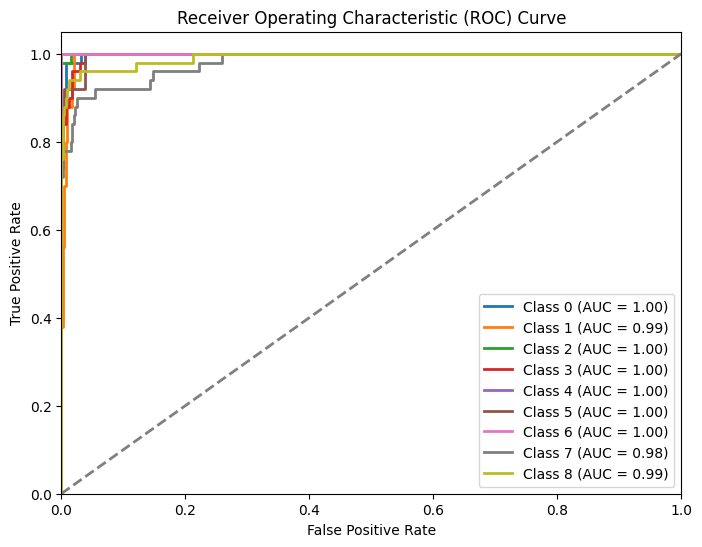

In [7]:
# Compute and print confusion matrix
cm = confusion_matrix(test_labels_np, predicted_np)
print("Confusion Matrix:")
print(cm)

# Receiver Operating Characteristic (ROC) Curve
all_probabilities = nn.functional.softmax(outputs, dim=1).numpy()
roc_auc = dict()
plt.figure(figsize=(8, 6))
for i in range(output_size):
    fpr, tpr, _ = roc_curve(test_labels_np == i, all_probabilities[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
# prompt: save the above model

torch.save(logreg.state_dict(), 'pest_classification_model.pt')


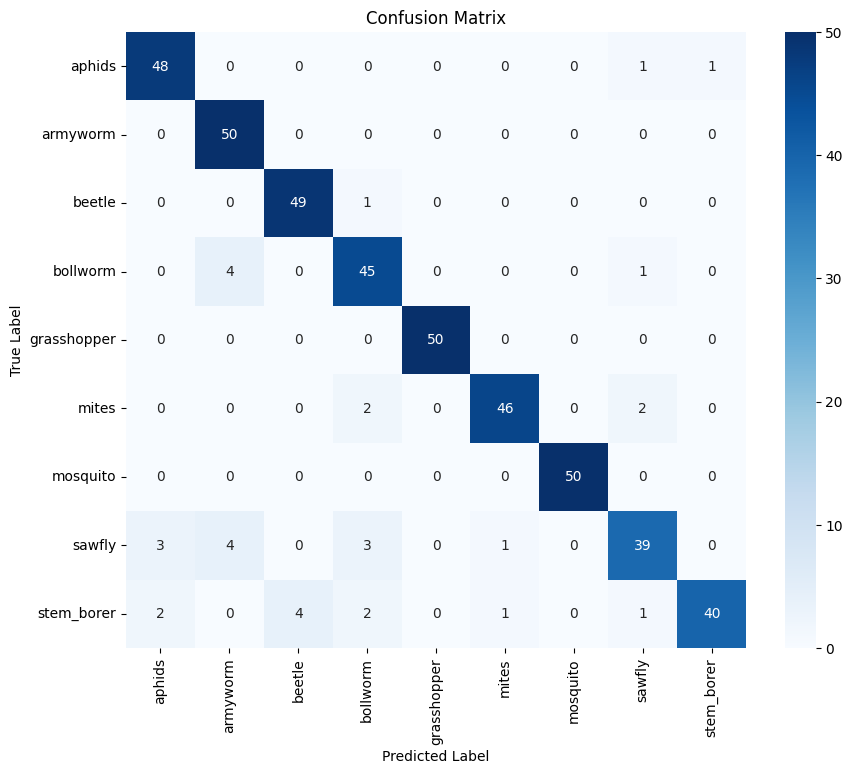

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Display Confusion Matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
